# Building Blocks

Here we will go step by step building tensorflow's wide and deep algorithm using pytorch. Needless to say, all credit for the original algorithm to Heng-Tze Cheng et al. Their paper can be found [here](https://arxiv.org/pdf/1606.07792.pdf) and the tutorial [here](https://www.tensorflow.org/tutorials/wide_and_deep). 

### 1-Prepare the data

As I mentioned in demo1 all you have to do is, once your dataframe is in a form similar to `DF` here, set the experiment and run `prepare_data`.

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
from wide_deep.data_utils import prepare_data

DF = pd.read_csv('data/adult_data.csv')
DF['income_label'] = (DF["income_bracket"].apply(lambda x: ">50K" in x)).astype(int)

wide_cols = ['age','hours_per_week','education', 'relationship','workclass',
             'occupation','native_country','gender']
crossed_cols = (['education', 'occupation'], ['native_country', 'occupation'])
embeddings_cols = [('education',10), ('relationship',8), ('workclass',10),
                    ('occupation',10),('native_country',10)]
continuous_cols = ["age","hours_per_week"]
target = 'income_label'
method = 'logistic'

wd_dataset = prepare_data(DF, wide_cols,crossed_cols,embeddings_cols,continuous_cols,target,scale=True)

`wd_dataset` is a dictionary with all the neccesary information. Let's have a look to for example, the `train_dataset`

In [2]:
wd_dataset['train_dataset']

train_dataset(wide=array([[46, 50,  0, ...,  0,  0,  0],
       [32, 45,  1, ...,  0,  0,  0],
       [30, 30,  0, ...,  0,  0,  0],
       ...,
       [40, 40,  0, ...,  0,  0,  0],
       [45, 37,  1, ...,  0,  0,  0],
       [40, 45,  1, ...,  0,  0,  0]]), deep=array([[ 3.        ,  1.        ,  6.        , ...,  0.        ,
         0.53655844,  0.77292975],
       [ 0.        ,  0.        ,  2.        , ...,  0.        ,
        -0.48456647,  0.36942139],
       [ 1.        ,  4.        ,  2.        , ...,  0.        ,
        -0.63044146, -0.84110367],
       ...,
       [ 1.        ,  0.        ,  2.        , ...,  0.        ,
         0.09893348, -0.03408696],
       [ 0.        ,  1.        ,  2.        , ...,  0.        ,
         0.46362095, -0.27619198],
       [ 0.        ,  1.        ,  2.        , ...,  0.        ,
         0.09893348,  0.36942139]]), labels=array([1, 0, 0, ..., 0, 0, 0]))

### 2-The model

The model is a combination of a linear classifier/regressor for sparse features (Wide) plus a neural network classifier/regressor that receives the embeddings. The figure below, taken from the [tutorial](https://www.tensorflow.org/tutorials/wide_and_deep), is a good illustration on how the algorithm works.

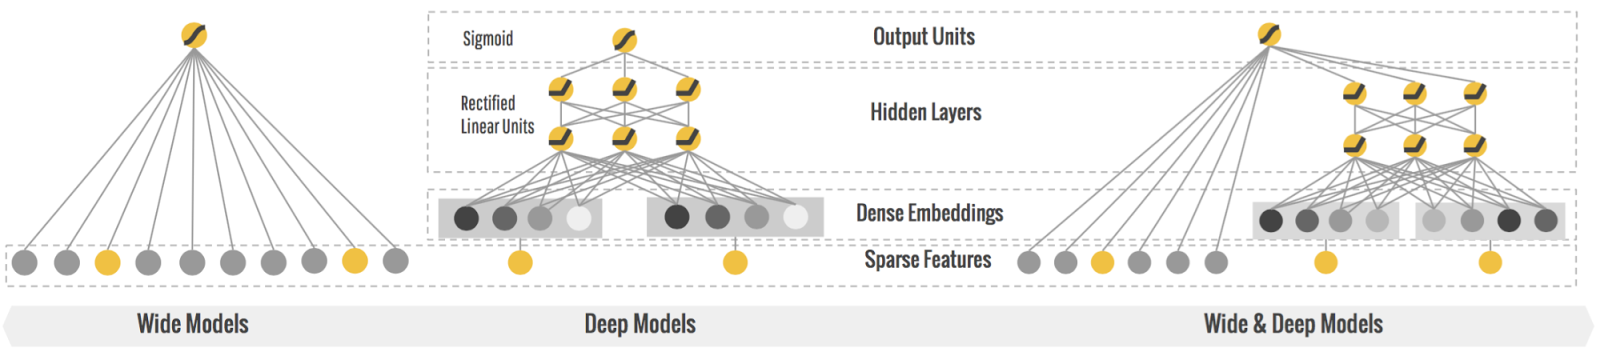

In [24]:
from IPython.display import Image
PATH = "./image04.png"
Image(filename = PATH, width=1000, height=500)

A priori, "all" we have to do is:

1. Prepare the wide part

2. Prepare the deep part

3. combine them

So...let's go!

### 2_1. The Wide Part

The wide part consist simply in the sparse features connected directly to the output neuron (or neurons if the problem is a multiclass classification). In the example here we will perform a logistic regression, so we need to connect the input features to an output neuron and use a *Sigmoid* activation function. 

In our case, this could be done like this:

In [4]:
import torch.nn as nn
import torch.nn.functional as F

wide_dim = wd_dataset['train_dataset'].wide.shape[1]
n_class  = 1
wide_part = nn.Linear(wide_dim, n_class)

print(wide_part)

Linear(in_features=798, out_features=1, bias=True)


Of course, we want our code to look pretty and be functional. When using pytorch, models are normally defined as classes (although if the are simple enough one could use the `Sequential` API) that inherit the methods from the `nn` module. Let's define the wide part properly and see how to use it. 

In [5]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.autograd import Variable
from torch.utils.data import DataLoader

class Wide(nn.Module):
    """
    Wide-side consists in simply in "pluging" the features into the output neuron(s)

    Parameters:
    ----------
    wide_dim: int. Number of features per observation
    method  : str. Regression, logistic or multiclass
    n_class : int. number of classes. Defaults to 1 if logistic or regression
    """
    def __init__(self, wide_dim, n_class):

        super(Wide, self).__init__()
        self.wide_dim = wide_dim
        self.n_class = n_class

        self.linear = nn.Linear(self.wide_dim, self.n_class)

    def forward(self,X):

        out = torch.sigmoid(self.linear(X))

        return out


In [6]:
wide_dim = wd_dataset['train_dataset'].wide.shape[1]
n_class  = 1
wide_model = Wide(wide_dim, n_class)

In [7]:
print(wide_model)

Wide(
  (linear): Linear(in_features=798, out_features=1, bias=True)
)


Ok, so far so good. We have simply created a model that consists of observations of 798 sparse features "plugged" into an output neuron that is activated with a *Sigmoid* function. Now, all we need to do is prepare the tensor to be passed through the model. Remember that the `prepare-data` function returns a dictionary with the wide and deep part arrays. Therefore, we can use the `train_dataset` to build the input tensor. 

Here the first column will be the target. 

In [8]:
wd_dataset['train_dataset'].labels.reshape(-1, 1).shape

(34189, 1)

In [9]:
train_dataset = np.hstack([wd_dataset['train_dataset'].labels.reshape(-1, 1), wd_dataset['train_dataset'].wide])
train_dataset

array([[ 1, 46, 50, ...,  0,  0,  0],
       [ 0, 32, 45, ...,  0,  0,  0],
       [ 0, 30, 30, ...,  0,  0,  0],
       ...,
       [ 0, 40, 40, ...,  0,  0,  0],
       [ 0, 45, 37, ...,  0,  0,  0],
       [ 0, 40, 45, ...,  0,  0,  0]])

Now we need to set up the training: optimizer, loss function, etc.

Pytorch provide a very handy functionality called `DataLoader`, at `torch.utils.data`. We will use if here to create the batches. Finally, the model needs to receive `Variables`. `Variables` support almost all operations you can perform on tensors. In addition, they define the computational graph, which will allow us later to automatically compute gradients. For more information read [here](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html#pytorch-variables-and-autograd).

In [10]:
optimizer = torch.optim.Adam(wide_model.parameters())
batch_size = 64
n_epochs = 10
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
# from http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
for epoch in range(n_epochs):
    total=0
    correct=0
    for i, batch in enumerate(train_loader):

        X_w = Variable(batch[:, 1:]).float()
        y = Variable(batch[:, 0]).float()

        optimizer.zero_grad()
        y_pred = wide_model(X_w)
        loss = F.binary_cross_entropy(y_pred, y.view(-1, 1))
        loss.backward()
        optimizer.step()

        total+= y.size(0)
        y_pred_cat = (y_pred > 0.5).squeeze(1).float()
        
        correct+= float((y_pred_cat == y).sum().item())
    print (correct, total)
    print ('Epoch {} of {}, Loss: {}, accuracy: {}'.format(epoch+1,
        n_epochs, round(loss.item(),3), round(correct/total,4)))

26682.0 34189
Epoch 1 of 10, Loss: 0.227, accuracy: 0.7804
28058.0 34189
Epoch 2 of 10, Loss: 0.374, accuracy: 0.8207
28261.0 34189
Epoch 3 of 10, Loss: 0.473, accuracy: 0.8266
28373.0 34189
Epoch 4 of 10, Loss: 0.17, accuracy: 0.8299
28475.0 34189
Epoch 5 of 10, Loss: 0.344, accuracy: 0.8329
28499.0 34189
Epoch 6 of 10, Loss: 0.573, accuracy: 0.8336
28530.0 34189
Epoch 7 of 10, Loss: 0.328, accuracy: 0.8345
28544.0 34189
Epoch 8 of 10, Loss: 0.301, accuracy: 0.8349
28568.0 34189
Epoch 9 of 10, Loss: 0.21, accuracy: 0.8356
28587.0 34189
Epoch 10 of 10, Loss: 0.248, accuracy: 0.8361


### 2_2. Deep part

Things get a bit more "colorful" here. 

Still, the deep part implemented here will be comprised by two layers of 100 and 50 neurons, so strictly speaking and under today's standards, is not very "deep". 

As mentioned earlier, the deep part receives embeddings and can also receive numerical features if one likes. The set up of the deep part is "stored" in our favourite dictionar `wd_dataset`. There we have two entries: 

In [11]:
print(wd_dataset['embeddings_input'])
print(wd_dataset['deep_column_idx'])

[('education', 16, 10), ('occupation', 15, 10), ('relationship', 6, 8), ('native_country', 42, 10), ('workclass', 9, 10)]
{'education': 0, 'relationship': 1, 'workclass': 2, 'occupation': 3, 'native_country': 4, 'age': 5, 'hours_per_week': 6}


These should be read as follows: the feature `workclass` has 9 unique values and it will be represented using 10 embeddings. In addition, in the input tensor to the deep part, `workclass` is at column 2. With this information, plus continuous columns list at the beginning of this notebook, we can build the deep part of the model.

In pytorch, embedding layers are defined as:

In [12]:
col_name, unique_vals, n_emb = wd_dataset['embeddings_input'][0]
emb_layer = nn.Embedding(unique_vals, n_emb)
print(emb_layer)

Embedding(16, 10)


Let's go:

In [13]:
class Deep(nn.Module):
    """
    Deep-side, which consists in a series of embeddings and numerical 
    features passed through a series of dense layers.

    Params:
    --------
    embeddings_input (tuple): 3-elements tuple with the embeddings "set-up" -
    (col_name, unique_values, embeddings dim)
    continuous_cols (list) : list with the name of the continuum columns
    deep_column_idx (dict) : dictionary where the keys are column names and the values
    their corresponding index in the deep-side input tensor
    hidden_layers (list) : list with the number of units per hidden layer
    n_class (int) : number of classes. Defaults to 1 if logistic or regression
    """
    def __init__(self,embeddings_input,continuous_cols,deep_column_idx,hidden_layers,n_class):

        super(Deep, self).__init__()
        self.deep_column_idx = deep_column_idx
        self.embeddings_input = embeddings_input
        self.continuous_cols = continuous_cols
        self.hidden_layers = hidden_layers
        self.n_class = n_class

        # build the embeddings that will be passed through the deep side    
        for col,val,dim in self.embeddings_input:
            setattr(self, 'emb_layer_'+col, nn.Embedding(val, dim))

        # the input dimension to the 1st hidden layer will be the sum of the
        # embeddings dimensions plus the number of continuous features
        input_emb_dim = np.sum([emb[2] for emb in self.embeddings_input])
        self.linear_1 = nn.Linear(input_emb_dim+len(continuous_cols), self.hidden_layers[0])
        for i,h in enumerate(self.hidden_layers[1:],1):
            setattr(self, 'linear_'+str(i+1), nn.Linear( self.hidden_layers[i-1], self.hidden_layers[i] ))

        self.output = nn.Linear(self.hidden_layers[-1], n_class)

    def forward(self, X):

        emb = [getattr(self, 'emb_layer_'+col)(X[:,self.deep_column_idx[col]].long())
               for col,_,_ in self.embeddings_input]

        cont_idx = [self.deep_column_idx[col] for col in self.continuous_cols]
        cont = [X[:, cont_idx].float()]

        deep_inp = torch.cat(emb+cont, 1)

        x_deep = F.relu(self.linear_1(deep_inp))
        for i in range(1,len(self.hidden_layers)):
            x_deep = F.relu( getattr(self, 'linear_'+str(i+1))(x_deep) )

        out = torch.sigmoid(self.output(x_deep))

        return out


Let's built the model and have a look:

In [14]:
deep_column_idx = wd_dataset['deep_column_idx']
embeddings_input= wd_dataset['embeddings_input']
hidden_layers = [100,50]
deep_model = Deep(embeddings_input, continuous_cols, deep_column_idx, hidden_layers, n_class)

In [15]:
print(deep_model)

Deep(
  (emb_layer_education): Embedding(16, 10)
  (emb_layer_occupation): Embedding(15, 10)
  (emb_layer_relationship): Embedding(6, 8)
  (emb_layer_native_country): Embedding(42, 10)
  (emb_layer_workclass): Embedding(9, 10)
  (linear_1): Linear(in_features=50, out_features=100, bias=True)
  (linear_2): Linear(in_features=100, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=1, bias=True)
)


As we can see, the deep part is comprised by: 

1. 5 embedding layers of dimensions 10, 10, 10, 8 and 10 respectively
2. The 5 embedding layers will be contactenated with the two continuous feaures (age and hours per week) so that the first hidden layer will receive tensors of dimensions (?, 10+10+10+8+10+2=50)
3. Two hidden layers of 100 and 50 neurons
4. The output neuron with a Sigmoid activation function

All left to do now is to build the input dataset and set up the training as we did before for the wide part. 

In [16]:
train_dataset = np.hstack([wd_dataset['train_dataset'].labels.reshape(-1, 1), wd_dataset['train_dataset'].deep])
train_dataset

array([[ 1.        ,  3.        ,  1.        , ...,  0.        ,
         0.53655844,  0.77292975],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.48456647,  0.36942139],
       [ 0.        ,  1.        ,  4.        , ...,  0.        ,
        -0.63044146, -0.84110367],
       ...,
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.09893348, -0.03408696],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
         0.46362095, -0.27619198],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
         0.09893348,  0.36942139]])

In [17]:
optimizer = torch.optim.Adam(deep_model.parameters())
batch_size = 64
n_epochs = 10
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

for epoch in range(n_epochs):
    total=0
    correct=0
    for i, batch in enumerate(train_loader):

        X_d = Variable(batch[:, 1:])
        y = Variable(batch[:, 0]).float()

        optimizer.zero_grad()
        y_pred = deep_model(X_d)
        loss = F.binary_cross_entropy(y_pred, y.view(-1, 1))
        loss.backward()
        optimizer.step()

        total+= y.size(0)
        y_pred_cat = (y_pred > 0.5).squeeze(1).float()
        correct+= float((y_pred_cat == y).sum().item())
        
    print ('Epoch {} of {}, Loss: {}, accuracy: {}'.format(epoch+1,
        n_epochs, round(loss.item(),3), round(correct/total,4)))

Epoch 1 of 10, Loss: 0.433, accuracy: 0.8252
Epoch 2 of 10, Loss: 0.487, accuracy: 0.8395
Epoch 3 of 10, Loss: 0.235, accuracy: 0.8427
Epoch 4 of 10, Loss: 0.706, accuracy: 0.8426
Epoch 5 of 10, Loss: 0.425, accuracy: 0.8443
Epoch 6 of 10, Loss: 0.495, accuracy: 0.8456
Epoch 7 of 10, Loss: 0.291, accuracy: 0.8463
Epoch 8 of 10, Loss: 0.181, accuracy: 0.8455
Epoch 9 of 10, Loss: 0.362, accuracy: 0.8474
Epoch 10 of 10, Loss: 0.158, accuracy: 0.8468


### Wide and Deep

Time to combine the two parts. The code below is mostly identical to that of the `Deep` class. The two main differences are: 

 1. The output neuron receives now the wide and the deep side, so the input dimensions need to be adapted in both the definition of the model
 
         self.output = nn.Linear(self.hidden_layers[-1]+self.wide_dim, n_class)
    
    and the forward pass  

        wide_deep_input = torch.cat([x_deep, X_w], 1)


Other than that, there are no major changes. 

In [18]:
class WideDeep(nn.Module):

    def __init__(self, wide_dim, embeddings_input, continuous_cols, deep_column_idx, hidden_layers, n_class):

        super(WideDeep, self).__init__()
        self.wide_dim = wide_dim
        self.deep_column_idx = deep_column_idx
        self.embeddings_input = embeddings_input
        self.continuous_cols = continuous_cols
        self.hidden_layers = hidden_layers
        self.n_class = n_class

        for col,val,dim in self.embeddings_input:
            setattr(self, 'emb_layer_'+col, nn.Embedding(val, dim))

        input_emb_dim = np.sum([emb[2] for emb in self.embeddings_input])
        self.linear_1 = nn.Linear(input_emb_dim+len(continuous_cols), self.hidden_layers[0])
        for i,h in enumerate(self.hidden_layers[1:],1):
            setattr(self, 'linear_'+str(i+1), nn.Linear( self.hidden_layers[i-1], self.hidden_layers[i] ))

        self.output = nn.Linear(self.hidden_layers[-1]+self.wide_dim, n_class)

    def forward(self, X_w, X_d):

        emb = [getattr(self, 'emb_layer_'+col)(X_d[:,self.deep_column_idx[col]].long())
               for col,_,_ in self.embeddings_input]

        cont_idx = [self.deep_column_idx[col] for col in self.continuous_cols]
        cont = [X_d[:, cont_idx].float()]

        deep_inp = torch.cat(emb+cont, 1)

        x_deep = F.relu(self.linear_1(deep_inp))
        for i in range(1,len(self.hidden_layers)):
            x_deep = F.relu( getattr(self, 'linear_'+str(i+1))(x_deep) )

        wide_deep_input = torch.cat([x_deep, X_w.float()], 1)

        out = torch.sigmoid(self.output(wide_deep_input))

        return out

Let's build the model and have a look to what is "inside"

In [19]:
wide_deep_model = WideDeep(wide_dim, embeddings_input, continuous_cols, deep_column_idx, hidden_layers, n_class)

In [20]:
wide_deep_model

WideDeep(
  (emb_layer_education): Embedding(16, 10)
  (emb_layer_occupation): Embedding(15, 10)
  (emb_layer_relationship): Embedding(6, 8)
  (emb_layer_native_country): Embedding(42, 10)
  (emb_layer_workclass): Embedding(9, 10)
  (linear_1): Linear(in_features=50, out_features=100, bias=True)
  (linear_2): Linear(in_features=100, out_features=50, bias=True)
  (output): Linear(in_features=848, out_features=1, bias=True)
)

As we see, everything is identical, apart from the output layer, which now receives all the features from the wide side plus the 50 dense features from the deep side. 

Finally, the `dataset` parameter in the `DataLoader` method needs to have  `__getitem__` and `__len__` methods itself. Here we would like to build a loader that returns, per batch, the wide and deep tensors. Therefore, I coded a simple class that will facilitate the loading and make the code more readable. 

In [21]:
class WideDeepLoader(Dataset):
    """Helper to facilitate loading the data to the pytorch models.

    Parameters:
    --------
    data: namedtuple with 3 elements - (wide_input_data, deep_inp_data, target)
    """
    def __init__(self, data):

        self.X_wide = data.wide
        self.X_deep = data.deep
        self.Y = data.labels

    def __getitem__(self, idx):

        xw = self.X_wide[idx]
        xd = self.X_deep[idx]
        y  = self.Y[idx]

        return xw, xd, y

    def __len__(self):
        return len(self.Y)


train_dataset = wd_dataset['train_dataset']
widedeep_dataset = WideDeepLoader(train_dataset)
train_loader = torch.utils.data.DataLoader(dataset=widedeep_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

At this stage, we are good to go:

In [22]:
optimizer = torch.optim.Adam(wide_deep_model.parameters())

batch_size = 64
n_epochs = 10
for epoch in range(n_epochs):
    total=0
    correct=0
    for i, (X_wide, X_deep, target) in enumerate(train_loader):
        X_d = Variable(X_deep)
        X_w = Variable(X_wide)
        y = Variable(target).float()

        optimizer.zero_grad()
        y_pred = wide_deep_model(X_w, X_d)
        loss = F.binary_cross_entropy(y_pred, y.view(-1,1))
        loss.backward()
        optimizer.step()

        total+= y.size(0)
        y_pred_cat = (y_pred > 0.5).squeeze(1).float()
        correct+= float((y_pred_cat == y).sum().item())

    print ('Epoch {} of {}, Loss: {}, accuracy: {}'.format(epoch+1,
        n_epochs, round(loss.item(),3), round(correct/total,4)))


Epoch 1 of 10, Loss: 0.144, accuracy: 0.8245
Epoch 2 of 10, Loss: 0.316, accuracy: 0.8384
Epoch 3 of 10, Loss: 0.262, accuracy: 0.8416
Epoch 4 of 10, Loss: 0.219, accuracy: 0.8421
Epoch 5 of 10, Loss: 0.311, accuracy: 0.8433
Epoch 6 of 10, Loss: 0.303, accuracy: 0.8439
Epoch 7 of 10, Loss: 0.478, accuracy: 0.844
Epoch 8 of 10, Loss: 0.366, accuracy: 0.8451
Epoch 9 of 10, Loss: 0.356, accuracy: 0.8477
Epoch 10 of 10, Loss: 0.544, accuracy: 0.8459


And that's it.

The code in this demo, with some minor rings and bells, is wrapped-up into a the class `WideDeep` at `wide_deep.torch_model` so is easy to use. 

If you want to see how to use it simply go to demo3. 